In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


# 1. Brief description of the problem and data


Twitter has become an important communication channel in times of emergency. It’s not always clear whether a person’s words are actually announcing a disaster. We are going to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. In this particular problem, we are dealing with text classification, which is the task of assigning a category or label to a given text based on its content.

The dataset that we are going to train the model consists of 10,000 tweets that have been hand-classified as either being about a real disaster (target = 1) or not (target = 0). 

The train dataset has 10,000 rows and 5 columns. The columns are:

*id: a unique identifier for each tweet.

*keyword: a keyword from the tweet (may be empty).

*location: the location from which the tweet was sent (may be empty).

*text: the text of the tweet.

*target: whether the tweet is about a real disaster (1) or not (0).

The test dataset has the same structure as the train dataset but does not include the target column. Both datasets may have some empty fields.

# 2. Exploratory Data Analysis (EDA) 

(7503, 5)
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
(7503, 5)
id             0
keyword       56
location    2482
text           0
target         0
dtype: int64


<AxesSubplot:xlabel='target', ylabel='Count'>

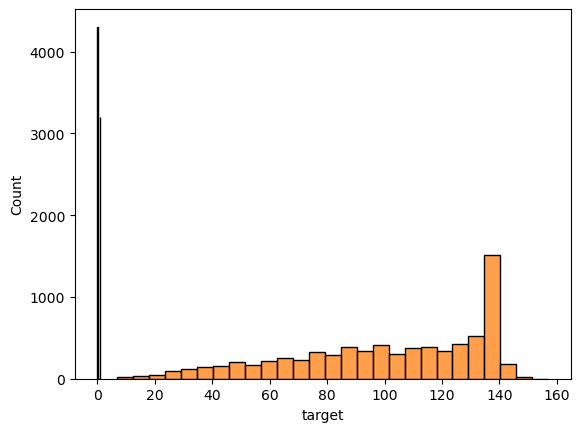

In [5]:
import pandas as pd
import seaborn as sns

train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

# Remove null lines
train_df = train_df.dropna(subset=['text'])

# Remove duplicates
train_df = train_df.drop_duplicates(subset=['text'])

# Reset the index
train_df = train_df.reset_index(drop=True)

# Check the new shape of the data
print(train_df.shape)

print(train_df.head())
print(train_df.shape)
print(train_df.isnull().sum())

sns.histplot(data=train_df, x='target')
train_df['length'] = train_df['text'].apply(len)
sns.histplot(data=train_df, x='length')

# 3. Model Architecture

The LSTM model is a type of recurrent neural network that can handle sequential data and capture long-term dependencies. It has a memory cell with three gates that control the flow of information into and out of the cell. To process the raw text data into word embeddings, we can use pre-trained models such as GloVe or Word2Vec. These models generate dense vector representations of words by training on large amounts of text data. To build and train our LSTM model, we can use a sequential neural network architecture with word embeddings as inputs and a binary classification label (1 or 0) as the output. We can experiment with different hyperparameters to optimize the performance of our model. The LSTM model is suitable for the given problem of classifying tweets as being about real disasters or not, as it can learn to recognize patterns in the text that are indicative of a real disaster tweet.

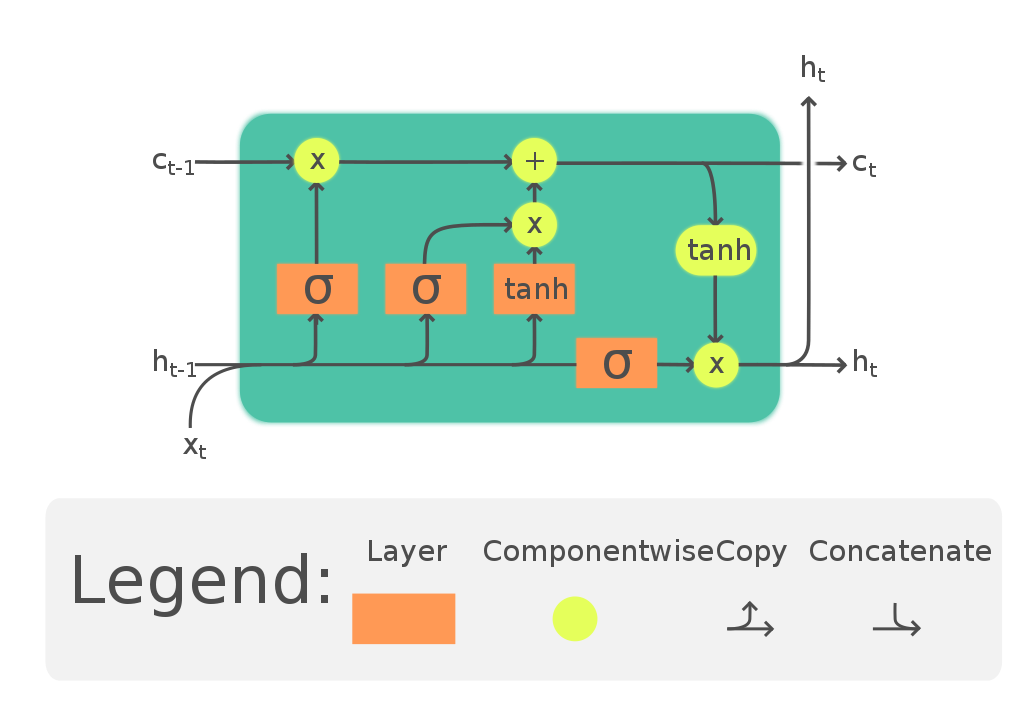


# 4. Results and Analysis

**4.1 Run the model**

In [8]:
# Import libraries
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Preprocess the data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['text'])
sequences = tokenizer.texts_to_sequences(train_df['text'])
X = pad_sequences(sequences, maxlen=100)
y = train_df['target'].values

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(Embedding(10000, 128, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10
188/188 [==============================] - 40s 191ms/step - loss: 0.5337 - accuracy: 0.7254 - val_loss: 0.4571 - val_accuracy: 0.7948
Epoch 2/10
188/188 [==============================] - 35s 186ms/step - loss: 0.3269 - accuracy: 0.8642 - val_loss: 0.5102 - val_accuracy: 0.7935
Epoch 3/10
188/188 [==============================] - 35s 185ms/step - loss: 0.2213 - accuracy: 0.9190 - val_loss: 0.5292 - val_accuracy: 0.7828
Epoch 4/10
188/188 [==============================] - 35s 185ms/step - loss: 0.1616 - accuracy: 0.9407 - val_loss: 0.6395 - val_accuracy: 0.7668
Epoch 5/10
188/188 [==============================] - 35s 185ms/step - loss: 0.1126 - accuracy: 0.9607 - val_loss: 0.7317 - val_accuracy: 0.7708
Epoch 6/10
188/188 [==============================] - 35s 188ms/step - loss: 0.0888 - accuracy: 0.9695 - val_loss: 0.8192 - val_accuracy: 0.7255
Epoch 7/10
188/188 [==============================] - 35s 186ms/step - loss: 0.0750 - accuracy: 0.9758 - val_loss: 0.8132 - val_ac

**4.2 Evaluate the model's performance**

In [14]:
# Import necessary libraries
from sklearn.metrics import f1_score

# Make predictions on the validation data
y_val_pred_probs = model.predict(X_val)

# Convert predicted probabilities to binary labels
y_val_pred = (y_val_pred_probs > 0.5).astype(int).flatten()

# Calculate the F1 score
f1 = f1_score(y_val, y_val_pred)

# Print the F1 score
print("F1 Score on Validation Data:", f1)

47/47 [==============================] - 2s 26ms/step
F1 Score on Validation Data: 0.7172995780590717


The F1 Score on Validation Data is 0.717.

In [15]:
# Load the test dataset
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Preprocess the test data
test_sequences = tokenizer.texts_to_sequences(test_df['text'])
X_test = pad_sequences(test_sequences, maxlen=100)

# Make predictions on the test data
y_test_pred_probs = model.predict(X_test)

# Convert predicted probabilities to binary labels
y_test_pred = (y_test_pred_probs > 0.5).astype(int).flatten()

# Create a DataFrame with the test dataset's IDs and the predicted labels
submission_df = pd.DataFrame({'id': test_df['id'], 'target': y_test_pred})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)


102/102 [==============================] - 3s 26ms/step


# Conclusion

The model architecture used is an LSTM (Long Short-Term Memory) model with an Embedding layer, an LSTM layer, and a Dense layer.
The model was trained for 10 epochs with a batch size of 32. After each epoch, the model's performance was evaluated using the validation data (X_val, y_val), and the validation loss and accuracy were reported. The model's best validation accuracy was achieved during the first epoch, with a validation accuracy of 0.7948 (79.48%). The F1 score on the validation data after training was 0.7173, which indicates a moderate performance in terms of both precision and recall. As the training progressed, the model started to overfit, as evidenced by the increase in validation loss and the decrease in validation accuracy after the second epoch.